# Sky segmentation with Unet. Training on sky binary maps


##


## Get the Dataset ready : Prepare COCO or ADE20K

### Checkout **00_Dataset** folder for preparation notebook and scripts


## Import 

In [1]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import functional as F
import cv2
import numpy as np

torch.manual_seed(17)

/home/cstrauss/anaconda3/envs/fast/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Free some GC memory, useful in case CUDA OOM error

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()



In [3]:
torch.cuda.is_available()

True

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Quadro T2000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Fastai Unet

In [5]:
from fastai.vision.all import *

### Dataloader

- define how to get images, how to get masks from image names, hos to read the mask 
- Mask is divided by 255 : 0 for bkg, 1 for sky
- create code list accordingly

In [6]:
import posixpath


def get_images(path):
    all_files = get_image_files(path)
    images = [i for i in all_files if str(i).endswith("jpg")]
    return images

def get_label(im_path):
    return ( posixpath.normpath(im_path) + '_skyMask.png')

In [17]:
TrainingFolderPath = Path('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/')
#TrainingFolderPath = Path('/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/ADE20kSky/')

all_images = get_images(TrainingFolderPath)
all_images
get_label(all_images[0])

'/home/cstrauss/PERSO/progo/orpogSkySeg/00_Dataset/cocoSky/000000133567.jpg_skyMask.png'

In [18]:
codes = ['bkg' , 'sky']
#codes[255] = 'y'

def get_msk(fn):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = get_label(fn)
    msk = np.array(PILImageBW.create(fn))/255
    return PILMask.create(msk)


def get_y(o): return get_msk(o)


### Create dataloader

- use augmentation and normalize to imagenet target, as we will use pretrained network latter on

- see https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb for a proper exemple


In [19]:
def get_dls(bs, size, scale = 0.7):
    segmentation_datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                       get_items=get_images,
                                       get_y=get_y,
                                       splitter=RandomSplitter(seed=42, valid_pct=0.2),
                                       item_tfms=[Resize(int(size*4), method=ResizeMethod.Squish)],
                                       batch_tfms=[*aug_transforms(size=size, min_scale=scale, min_zoom=0.5, max_zoom=2, mult = 2),
                                                   Normalize.from_stats(*imagenet_stats)])
    #segmentation_datablock.summary(TrainingFolderPath)
    return segmentation_datablock.dataloaders(TrainingFolderPath, bs=bs)


# this one is not needed at training time
def get_dls_no_transform(bs, size):
    segmentation_datablock2 = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                       get_items=get_images,
                                       get_y=get_y,
                                       splitter=RandomSplitter(seed=42),
                                       item_tfms=[],
                                       batch_tfms=[Normalize.from_stats(*imagenet_stats)])

    return segmentation_datablock2.dataloaders(TrainingFolderPath, bs=bs, device=torch.device('cuda'))
    # batch_tfms = [RandomResizedCrop(input_size, min_scale=0.05, max_scale=0.15), Normalize.from_stats(*imagenet_stats)]


Check a training batch

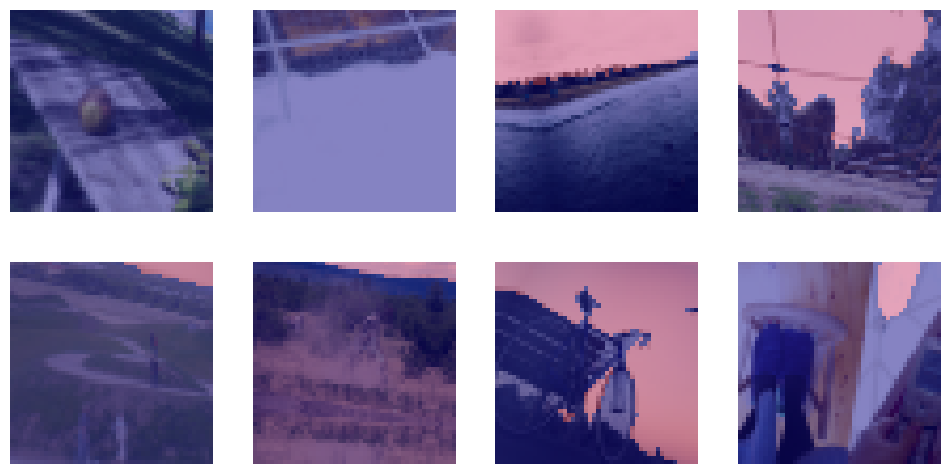

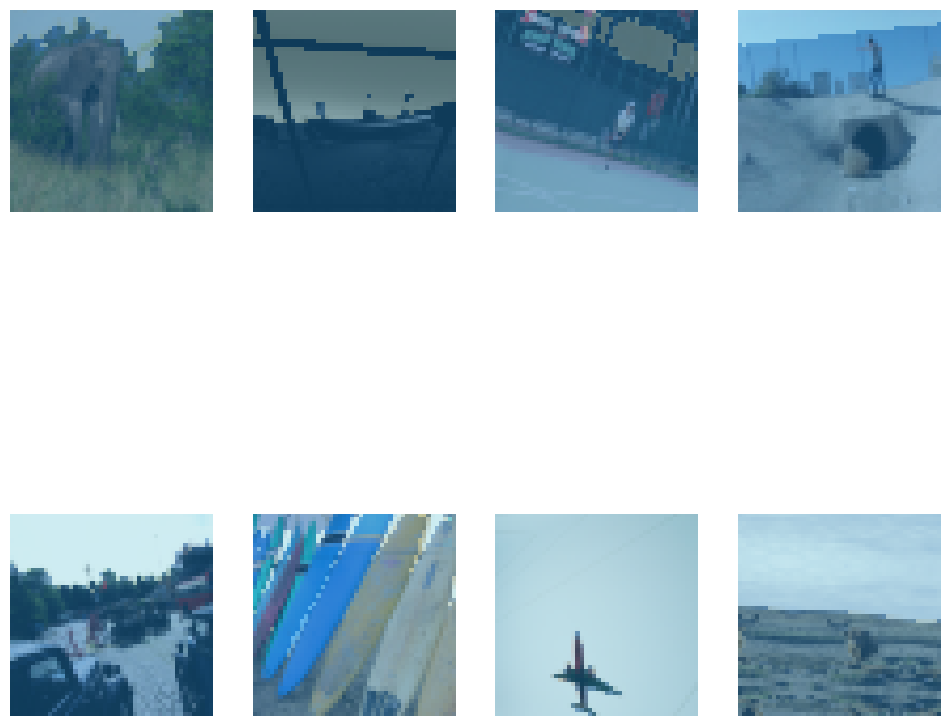

In [20]:
bs = 8
dls = get_dls(bs, 48, 0.3)
dls.show_batch(cmap='plasma')

dls.show_batch(vmin=0,vmax=1,figsize=(12, 12))


# Unet training

- Note : fp16 (mixed precision) model training has been tried, but something wrong as loss is always NaN on my machine (is it a graphic card issue?)
--> test it on tpu ? 

- Pick a resnet18 as architecture as it is small and 'fast' to train

https://pytorch.org/vision/main/models.html



In [14]:
# SqueezeNet resnet18 resnet34 mobilenet_v3_small shufflenet_v2_x0_5 shufflenet_v2_x2_0 regnet_x_400mf
learn = unet_learner(dls,  resnet18)

/home/cstrauss/anaconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cstrauss/anaconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 shufflenet_v2_x2_0 : plateau @ 0.18 validation : very fast to train, lr 1e-3
 regnet_x_400mf : in the resnet18 in terms of learning speed

# Find the learning rate


for Unet with Resnet18, bs=4, res=224, LR is in the 1e-5 - 1e-4 range seems consistent

In [15]:
#%%script echo skipping

#learn.lr_find()

#print(learn.model)

#!pip install SemTorch

from semtorch import get_segmentation_learner

dls = get_dls(bs, 224, 0.3)
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[Dice(), JaccardCoeff()],wd=1e-2)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.179807,0.140901,00:40
1,0.199949,0.133491,00:40
2,0.195220,0.130317,00:39


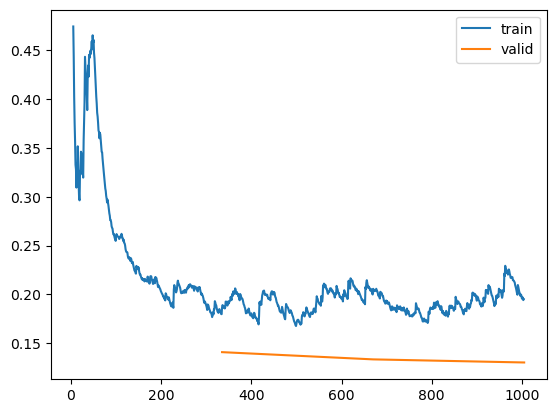

In [21]:
learn.dls = get_dls(4, 112, 0.3)
base_lr = 1e-5
learn.freeze() # do not train the pretrained part
learn.fit_one_cycle(3, base_lr, cbs=GradientAccumulation(n_acc=12))

learn.recorder.plot_loss()

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.089950,0.061778,0.894384,0.808947,18:06
1,0.069843,0.060697,0.890494,0.802604,17:54
2,0.077921,0.060744,0.893593,0.807653,17:55


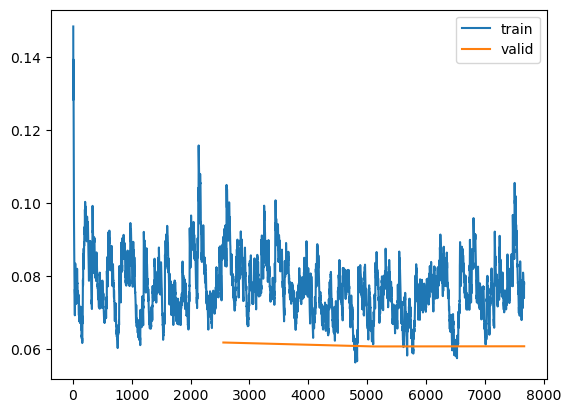

In [23]:
base_lr = 1e-5
learn.unfreeze() # do not train the pretrained part
learn.fit_one_cycle(3, base_lr)

learn.recorder.plot_loss()

# Train with Progressive resizing

**For faster training** : start at lower resolution for the firsts epochs then move to the targeted size

- Note : the network weights size stay the same (architecture is constant). Forward pass is faster on smaller images

- see https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb for exemple

SuggestedLRs(valley=0.0063095735386013985)

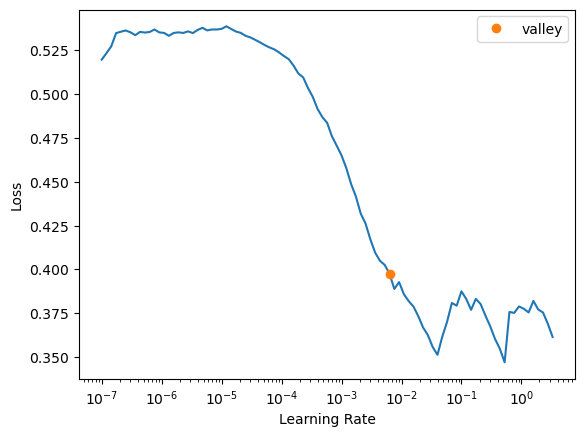

In [16]:
#learn.dls = get_dls(1, 224)
learn.lr_find()

In [14]:
(2**5)


32

In [26]:

(2**2) * 64

256

In [27]:
class dls_update_Callback(Callback):
    aSize = 224 / (2**2)
    aBs = (2**2) * 64

    def before_epoch(self):
        if self.learn.epoch == 0:
            self.learn.dls = get_dls(int(self.aBs),  int(self.aSize))
            print("before epoch: batch size:",
                  self.aBs, " patch size: ", self.aSize)

    def after_epoch(self):
        self.aSize = int(min(224, self.aSize * 2))
        self.aBs = int(max(1, self.aBs / 4))

        self.learn.dls = get_dls(int(self.aBs),  int(self.aSize))
        print("after epoch: batch size:", self.aBs, " patch size: ", self.aSize)


In [17]:

base_lr = 1e-3
learn.dls = get_dls(8, 28)
learn.freeze() # do not train the pretrained part
learn.fit_one_cycle(3, base_lr, cbs=dls_update_Callback)

learn.recorder.plot_loss()



NameError: name 'dls_update_Callback' is not defined

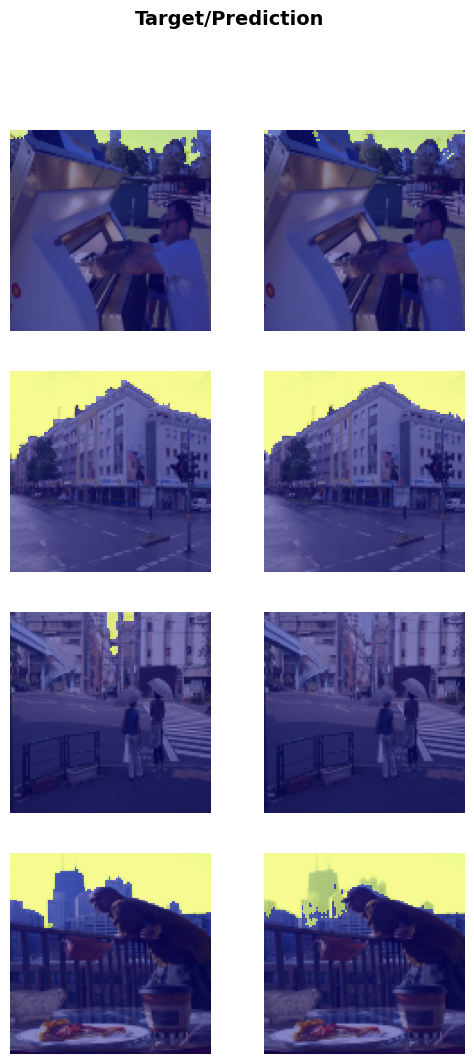

In [22]:
learn.show_results(cmap='plasma', vmin=0, vmax=1, shuffle=True)

In [ ]:

base_lr/=2

learn.dls = get_dls(4, 448)
learn.fine_tune(4, base_lr)

learn.recorder.plot_loss()

In [ ]:
base_lr/=2

learn.dls = get_dls(8, 112)
learn.fine_tune(2, base_lr)

learn.recorder.plot_loss()

In [ ]:
base_lr/=2

learn.dls = get_dls(4, 224)
learn.fine_tune(2, base_lr)

learn.recorder.plot_loss()

In [ ]:
base_lr/=2

learn.dls = get_dls(1, 448)
learn.fine_tune(2, base_lr)

learn.recorder.plot_loss()

In [36]:
learn.save ("modelStep1_DeeplabV3+_resnet18_20230222.fastai", with_opt=False)


Path('models/modelStep1_DeeplabV3+_resnet18_20230222.fastai.pth')

: 

Here is the code for fine_tune

```
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

```

- Note : fine_tune unfreeze the model : it also train the pretrained part

Keep training on the target Resolution, smaller batch size

# Check some result

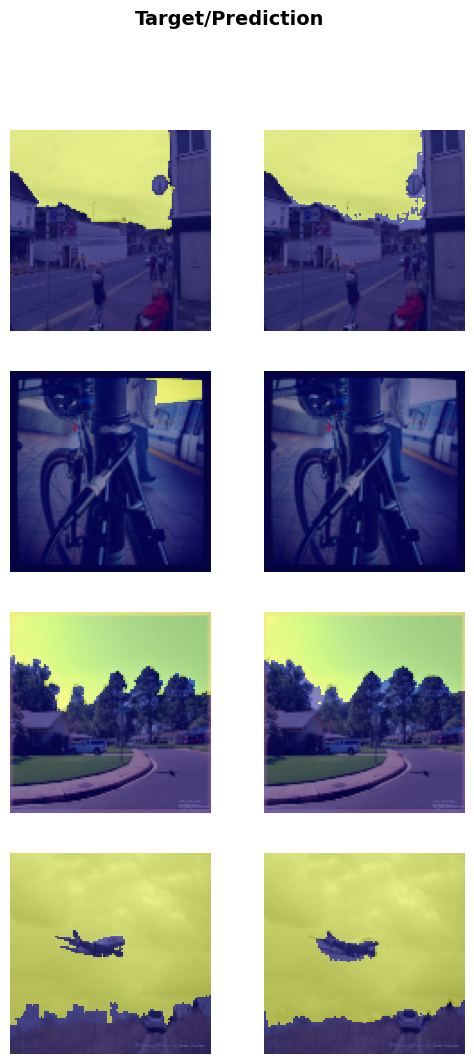

In [23]:
learn.show_results(cmap='plasma', vmin=0, vmax=1, shuffle=True)

# Show the worst predictions, some images are poorly labeled !

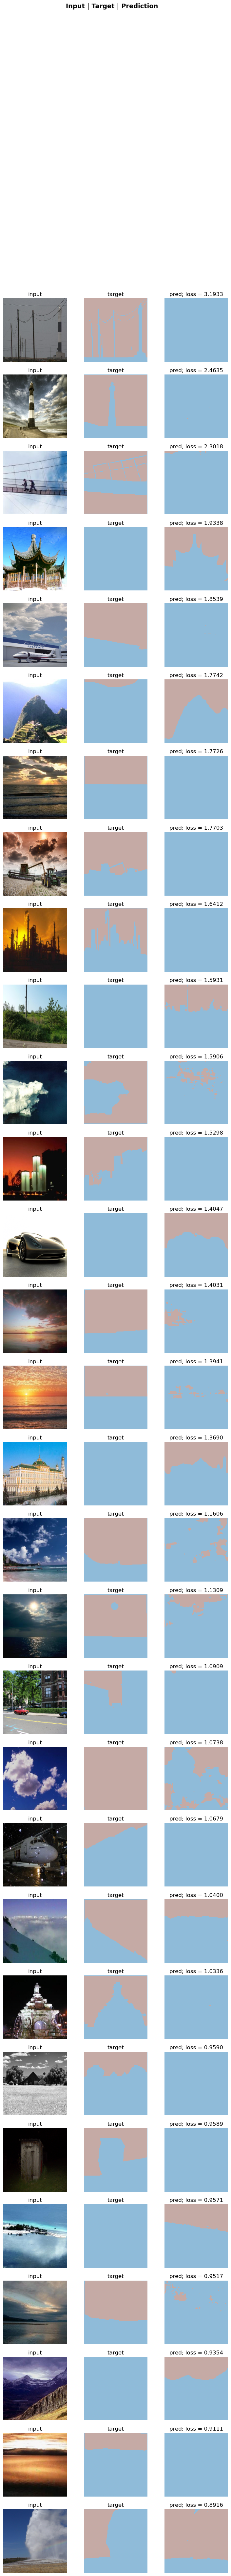

In [35]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=30)

In [ ]:
# !pip install torchsummary
#from torchsummary import summary
#summary(learn.model, (3, 224, 224))

#print(learn.model)